## DC Crime data analysis
### Mapping crimes

In [465]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

from shapely.geometry import box
from shapely.plotting import plot_polygon, plot_points
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore', category=Warning)


import torch

import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import geopandas as gpd
from torch_geometric.nn import GCNConv, SAGEConv,GATConv, ChebConv
from sklearn.metrics  import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
from sklearn.metrics import accuracy_score,precision_score, f1_score,roc_auc_score,max_error,recall_score
#seting up palette 
palette = ["#FAC8BE", "#80E1C6", "#FFB3E1", "#6CC3FC", "#FFD168", "#C894E1"]
sns.set(rc={"axes.facecolor":"#e6e6e6","figure.facecolor":"#f5f5f5"})
cmap = colors.ListedColormap( ["#FAC8BE", "#80E1C6", "#FFB3E1", "#6CC3FC", "#FFD168", "#C894E1"])


device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

In [466]:
# Load the dataset
df = pd.read_csv('./data/crime_dc.csv')

df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

df=df[df['start_date'].dt.year>2022]


df.index=pd.RangeIndex(start=0,stop=df.shape[0])
df=df.reset_index()

daily_counts = df['start_date'].dt.date.value_counts().sort_index()
weekly_counts = df['start_date'].dt.to_period('W').value_counts().sort_index()
monthly_counts = df['start_date'].dt.to_period('M').value_counts().sort_index()

df['day_of_week'] = df['start_date'].dt.dayofweek
weekday_counts = df['day_of_week'].value_counts().sort_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df['day_of_month'] = df['start_date'].dt.day
day_counts = df['day_of_month'].value_counts().sort_index()

df['hour'] = df['start_date'].dt.hour
hourly_counts = df['hour'].value_counts().sort_index()

df['month']=df['start_date'].dt.to_period('M')

df.loc[df['offense']=='ASSAULT W/DANGEROUS WEAPON','offense']='ASSAULT W/WEAPON'
# df.loc[df['offense']=='ASSAULT W/DANGEROUS WEAPON','offense']='ASSAULT W/WEAPON'

# other DC data

In [467]:


metro_lines = gpd.read_file('./data/dc-maps/maps/metro-lines.geojson')
atm = gpd.read_file('./data/dc-maps/maps/atm-banking.geojson')
banks = gpd.read_file('./data/dc-maps/maps/bank-locations.geojson')
gas = gpd.read_file('./data/dc-maps/maps/gas-stations.geojson')
hospitals = gpd.read_file('./data/dc-maps/maps/hospitals.geojson')
# benches = gpd.read_file('./data/dc-maps/maps/benches.geojson') # toomany
dc_boundary = gpd.read_file('./data/dc-maps/maps/dc-boundary.geojson')
district = gpd.read_file('./data/dc-maps/maps/district-mask.geojson')
libraries = gpd.read_file('./data/dc-maps/maps/libraries.geojson')
metro_stations=gpd.read_file('./data/dc-maps/maps/metro-station-entrances-district.geojson')
parks = gpd.read_file('./data/dc-maps/maps/national-parks.geojson')
museums = gpd.read_file('./data/dc-maps/maps/museums-in-dc.geojson')
police_stations = gpd.read_file('./data/dc-maps/maps/police-stations.geojson')
shuttle_bus = gpd.read_file('./data/dc-maps/maps/shuttle-bus-stops.geojson')
shopping_centers = gpd.read_file('./data/dc-maps/maps/shopping-centers.geojson')
camera = gpd.read_file('./data/dc-maps/maps/camera-enforcement-locations.geojson')
grocery=gpd.read_file('./data/dc-maps/maps/grocery-store-locations.geojson')
metro_bus = gpd.read_file('./data/dc-maps/maps/metro-bus-stops.geojson')
post_office = gpd.read_file('./data/dc-maps/maps/post-offices.geojson')
schools = gpd.read_file('./data/dc-maps/maps/public-schools.geojson')

In [468]:
def fishnet(geometry, step=0.01):
    bounds = geometry.bounds
    xmin,ymin,xmax,ymax=bounds
    result = []
    for i in np.arange(xmin, xmax, step):
        for j in np.arange(ymin, ymax, step):
            b = box(i, j, i+step, j+step)
            g = geometry.intersection(b)
            if g.is_empty:
                continue
            result.append(g)
    return result



# polygon=dc_boundary['geometry'][0]
# res=fishnet(polygon, 0.05)
# nets=gpd.GeoDataFrame(geometry=res)
# nets['index']=range(len(nets))

In [469]:
def count_close_building(crime_data, buildings, new_col_name='counts', max_distance=0.002):
    data=crime_data
    temp=data[['index','geometry']]
    buildings_location=buildings[['geometry']]

    # Find events within the buffered_museums
    # 1 degree is approximately 111 km;
    temp_buffered = gpd.sjoin_nearest( temp, buildings_location, how='left',max_distance=max_distance,distance_col='distance')
    temp_buffered=temp_buffered[~temp_buffered['index_right'].isnull()]

    counts=pd.DataFrame(temp_buffered.groupby('index').size().rename(new_col_name))

    temp_merged=temp.merge(counts,left_on='index', right_on='index', how='left').fillna(0)

    return temp_merged


In [470]:
# make crime_data a geopanda frame
df['geometry'] = gpd.points_from_xy(df['longitude'], df['latitude'])
crime_data = gpd.GeoDataFrame(df, crs="EPSG:4326")

temp=count_close_building(crime_data,museums,'museums_count')
crime_data.loc[:,'museums_count']=temp.loc[:,'museums_count']

col_name='gas'
temp=count_close_building(crime_data,gas,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='metro_bus'
temp=count_close_building(crime_data,metro_bus,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='atm'
temp=count_close_building(crime_data,atm,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='banks'
temp=count_close_building(crime_data,banks,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='grocery'
temp=count_close_building(crime_data,grocery,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='metro_stations'
temp=count_close_building(crime_data,metro_stations,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='post_office'
temp=count_close_building(crime_data,post_office,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='schools'
temp=count_close_building(crime_data,schools,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='libraries'
temp=count_close_building(crime_data,libraries,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]

col_name='shuttle_bus'
temp=count_close_building(crime_data,shuttle_bus,col_name)
crime_data.loc[:,col_name]=temp.loc[:,col_name]



## Clusters

In [471]:
def merge_into_nets(nets,geo_data, count_name='counts'):
    # find the net for each incident
    buffer_length_in_meters = 0.001
    geo_data=geo_data[:]
    geo_data.geometry=geo_data.buffer(buffer_length_in_meters)
    geo_data = gpd.sjoin(geo_data,nets, how='left', op='intersects')
    # group by the net
    counts=geo_data.groupby('index_right').size().rename(count_name)
    # merge the group count back to nets
    geo_data=nets.merge(counts, left_on='index', right_on='index_right', how='left')
    
    geo_data=geo_data.fillna(0)
    return geo_data

In [472]:
def create_network(mesh_size=0.01):
    polygon=dc_boundary['geometry'][0]
    res=fishnet(polygon, mesh_size)
    nets=gpd.GeoDataFrame(geometry=res)
    nets['index']=range(len(nets))
    # print(nets.shape)

#     crime_net_agg=merge_into_nets(nets,crime_data.iloc[:,1:],count_name='all_crime_counts')
    crime_net_agg=merge_into_nets(nets,libraries,count_name='libraries')
    crime_net_agg=merge_into_nets(crime_net_agg,atm,count_name='atm')
    crime_net_agg=merge_into_nets(crime_net_agg,banks,count_name='banks')
    crime_net_agg=merge_into_nets(crime_net_agg,gas,count_name='gas')
    crime_net_agg=merge_into_nets(crime_net_agg,metro_stations,count_name='metro_stations')

    crime_net_agg=merge_into_nets(crime_net_agg,parks,count_name='parks')
    crime_net_agg=merge_into_nets(crime_net_agg,museums,count_name='museums')
    crime_net_agg=merge_into_nets(crime_net_agg,police_stations,count_name='police_stations')
    crime_net_agg=merge_into_nets(crime_net_agg,shopping_centers,count_name='shopping_centers')

    # crime_net_agg=merge_into_nets(crime_net_agg,theft_other.iloc[:,1:],count_name='theft_o')
    # crime_net_agg=merge_into_nets(crime_net_agg,theft_auto.iloc[:,1:],count_name='theft_auto')
    # crime_net_agg=merge_into_nets(crime_net_agg,theft_v.iloc[:,1:],count_name='theft_v')

    # crime_net_agg=merge_into_nets(crime_net_agg,robbery.iloc[:,1:],count_name='robbery')
    # crime_net_agg=merge_into_nets(crime_net_agg,assault.iloc[:,1:],count_name='assault')
    # crime_net_agg=merge_into_nets(crime_net_agg,burglary.iloc[:,1:],count_name='burglary')

    # crime_net_agg=merge_into_nets(crime_net_agg,homicide.iloc[:,1:],count_name='homicide')
    # crime_net_agg=merge_into_nets(crime_net_agg,sexabuse.iloc[:,1:],count_name='sexabuse')
    # crime_net_agg=merge_into_nets(crime_net_agg,arson.iloc[:,1:],count_name='arson')

    # crime_net_agg=merge_into_nets(crime_net_agg,gun.iloc[:,1:],count_name='gun')
    # crime_net_agg=merge_into_nets(crime_net_agg,knife.iloc[:,1:],count_name='knife')
    # crime_net_agg=merge_into_nets(crime_net_agg,methods_others.iloc[:,1:],count_name='methods_others')

    crime_net_agg=merge_into_nets(crime_net_agg,camera,count_name='camera')
    crime_net_agg=merge_into_nets(crime_net_agg,grocery,count_name='grocery')
    crime_net_agg=merge_into_nets(crime_net_agg,metro_bus,count_name='metro_bus')
    crime_net_agg=merge_into_nets(crime_net_agg,post_office,count_name='post_office')
    crime_net_agg=merge_into_nets(crime_net_agg,schools,count_name='schools')
    crime_net_agg=merge_into_nets(crime_net_agg,shuttle_bus,count_name='shuttle_bus')

#     crime_net_agg=merge_into_nets(crime_net_agg,crime_data.iloc[:,1:],count_name='day_of_week')
#     crime_net_agg=merge_into_nets(crime_net_agg,crime_data.iloc[:,1:],count_name='hour')

    net_fix_orig=crime_net_agg[['atm','gas','banks','metro_stations','parks','museums','police_stations','post_office',
                           'shopping_centers','grocery','metro_bus','shuttle_bus']]


    net_fix=torch.from_numpy(net_fix_orig.values).float()
    net_fix=net_fix.to(device)

    # create a graph
    edge_index_start=[]
    edge_index_end=[]

    for idx_i in range(nets.shape[0]):
        net1=nets.iloc[idx_i,0]
        for idx_j in range(idx_i+1, nets.shape[0]):
            net2=nets.iloc[idx_j,0]
            if net1.dwithin(net2, mesh_size/5):
                edge_index_start.append(idx_i)
                edge_index_end.append(idx_j)
                edge_index_start.append(idx_j)
                edge_index_end.append(idx_i)

    edge_index=torch.cat((torch.tensor(edge_index_start).reshape(-1,1),torch.tensor
                          (edge_index_end).reshape(-1,1)),dim=1).long()
    edge_index=edge_index.t().contiguous().to(device)
    return nets, net_fix, edge_index, net_fix_orig

In [182]:
nets, net_fix, edge_index, nets_orig=create_network(0.005)

In [185]:
nets_orig.iloc[310:311]

,atm,gas,banks,metro_stations,parks,museums,police_stations,post_office,shopping_centers,grocery,metro_bus,shuttle_bus
310,6.0,2.0,5.0,1.0,2.0,0.0,0.0,1.0,0.0,2.0,15.0,0.0


In [17]:
# get the Jan data
jan_crimes=crime_data[
    np.logical_or(np.logical_or(crime_data['month']=='2023-01' , crime_data['month']=='2023-02'),
    crime_data['month']=='2023-03') ]
jan_crimes=jan_crimes.loc[jan_crimes.offense_group == 'violent'] # property, violent



## time series model

In [512]:
nets.to_file('./models/nets_for_trained_model')

In [177]:
# column 0 is geoinfo, column 1 is index, need to be removed
SEQ=7
X=[]
y=[]
y_c=[]
for i in range(ts.shape[1]-SEQ-3):
    i=i+2 # skip index and geo column
    t=ts.iloc[:,i:i+SEQ].values
    t_next=ts.iloc[:,i+1:i+1+SEQ].values
    X.append(t_next-t)
    y.append(ts.iloc[:,i+SEQ:i+SEQ+1].values)   
    y_c.append(np.hstack((ts.iloc[:,i+SEQ:i+SEQ+1].values<=0,ts.iloc[:,i+SEQ:i+SEQ+1].values>0)))   
X=np.array(X)
y=np.array(y)
y_c=np.array(y_c).astype(float)
X.shape

# Split in train-test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=False, random_state=0)
train_size=Y_train.shape[0]
val_size=Y_val.shape[0]
test_size=Y_test.shape[0]

# transform to torch dataset
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_val = torch.from_numpy(X_val).float()
Y_val = torch.from_numpy(Y_val).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()
train_tensor = torch.utils.data.TensorDataset(X_train, Y_train) 
val_tensor = torch.utils.data.TensorDataset(X_val, Y_val) 
test_tensor = torch.utils.data.TensorDataset(X_test, Y_test) 
train_data_loader = torch.utils.data.DataLoader(train_tensor, batch_size=128,shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_tensor, batch_size=128,shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_tensor, batch_size=128,shuffle=False)



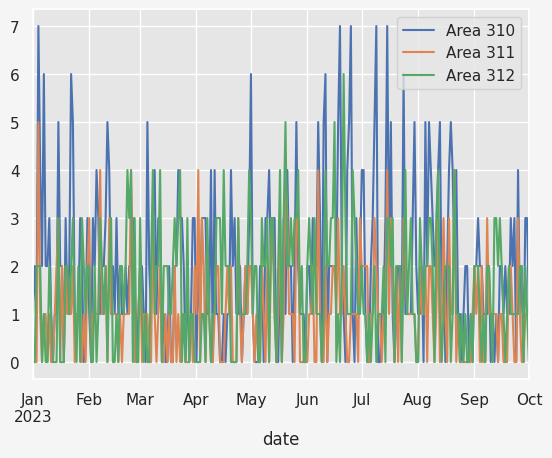

In [489]:
pt[310].plot(label='Area 310')
pt[311].plot(label='Area 311')
pt[312].plot(label='Area 312')
plt.legend()
plt.savefig('./ts_3areas.png',dpi=300, bbox_inches='tight')

In [219]:
# class GnnModel(torch.nn.Module):

#     def __init__(self, gnn='SAGE', hs=32, layers=1, heads=4) -> None:
#         super().__init__()
#         self.hs=hs
#         self.layers=layers
#         self.model_desc=f'Gnn model HS: {self.hs}, gnn:{gnn}, layers:{layers}, heads:{heads}'
        
#         if gnn=='SAGE':
#             self.gnn=SAGEConv(SEQ, hs,aggr='mean',normalize=False)
# #             self.gnn=nn.Linear(SEQ,hs)
# #             self.gnn1=nn.Linear(hs+hs, hs)
#             self.gnn1=SAGEConv(hs+hs, hs,aggr='mean',normalize=False)
#             self.gnn2=SAGEConv(hs, hs,aggr='mean',normalize=False)
#             self.gnn3=SAGEConv(hs, hs,aggr='mean',normalize=False)
#         elif gnn=='GCN':
#             self.gnn=GCNConv(SEQ, hs,aggr='mean',normalize=False)
# #             self.gnn=nn.Linear(SEQ,hs)
#             self.gnn1=GCNConv(hs+hs, hs,aggr='mean',normalize=False)
#             self.gnn2=GCNConv(hs, hs,aggr='mean',normalize=False)
#             self.gnn3=GCNConv(hs, hs,aggr='mean',normalize=False)
            
#         self.gnn_network=GATConv(8, hs,heads=heads, concat=False)
#         self.gnn_network1=GATConv(hs, hs,heads=heads, concat=False)
        
#         self.fc0=nn.Linear(hs,hs)
#         self.fc1=nn.Linear(hs, 1)
#         self.fc_classfication=nn.Linear(hs,2)
#         self.dropout = nn.Dropout(p=0.1)

#     def forward(self, x):#     torch.Size([77, 226, 28]) input training batch 128

#         network=net_fix
#         network=self.dropout(F.relu(self.gnn_network(network, edge_index)))
#         network=self.dropout(F.relu(self.gnn_network1(network, edge_index)))
#         network=network.repeat(x.shape[0],1,1)
      
#         x=self.dropout(F.relu(self.gnn(x,edge_index)))
#         x=torch.cat((x,network),dim=-1)
#         x=self.dropout(F.relu(self.gnn1(x, edge_index)))
#         if self.layers==2:
#             x=self.dropout(F.relu(self.gnn2(x, edge_index)))
#         if self.layers==3:
#             x=self.dropout(F.relu(self.gnn3(x, edge_index)))
#         x=self.dropout(F.relu(self.fc0(x)))
#         x_pred=self.fc1(x)
#         x_c=self.fc_classfication(x)
#         return x_pred, x_c

In [291]:
result={}
len(result.keys())

0

In [473]:

# Initialize the model
def train(model,train_loader,optimizer,crit, crit_c):
    model.train()
    loss_all = 0
    for idx,data in enumerate(train_loader):
        data[0] = data[0].to(device)
        data[1] = data[1].to(device)
        
        optimizer.zero_grad()
        output,output_c = model(data[0]) #torch.Size([128, 69, 1]),torch.Size([128, 69, 2]) torch.Size([128, 69, 1])
#         print(f'{output.shape},{output_c.shape} {data[1].shape}')
        y_c=torch.concat([data[1]<=0,data[1]>0],dim=-1)
        y_c=torch.tensor(y_c,dtype=torch.float32)
#         print(data[1].shape, y_c.shape)
        loss = crit(output, data[1])
        loss += crit_c(output_c, y_c)
        loss.backward()

        loss_all += loss.item()
        optimizer.step()
    return loss_all/(len(train_loader.dataset)*nets.shape[0])

def test(model,test_loader,crit,crit_c):
    model.eval()
    loss_all=0
    with torch.no_grad():
        pred=[]
        pred_c=[]
        pred_c_prob=[]
        gt=[]
        gt_c=[]
        for idx,data in enumerate(test_loader):
            x, y =data[0].to(device), data[1].to(device)
#             print('test, y:', y.shape)
            temp, temp_c=model(x)
            y_gt_c=torch.concat([y<=0,y>0],dim=-1)
            y_gt_c=torch.tensor(y_gt_c,dtype=torch.float32)

            y_pred=temp.detach().cpu().numpy()
            y_pred_c=torch.argmax(temp_c,dim=-1,).unsqueeze(-1).detach().cpu().numpy()
#             print(temp_c.shape, y_gt_c.shape)
            loss = crit(temp, y)
            loss += crit_c(temp_c, y_gt_c)
            loss_all=loss_all+loss.item()
            
            y_gt=y.cpu().numpy()
            if len(pred)==0:
                pred=y_pred
                pred_c=y_pred_c
                gt=y_gt
                gt_c=torch.argmax(y_gt_c,dim=-1,).unsqueeze(-1).cpu().numpy()
#                 pred_c_prob=temp_c.cpu().numpy()
            else:
                pred=np.concatenate((pred,y_pred),axis=0)
                pred_c=np.concatenate((pred_c,y_pred_c),axis=0)
                gt=np.concatenate((gt,y_gt),axis=0)
                gt_c=np.concatenate((gt_c,torch.argmax(y_gt_c,dim=-1,).unsqueeze(-1).cpu().numpy()),axis=0)
#                 pred_c_prob=np.concatenate((pred_c_prob,temp_c.cpu().numpy()),axis=0)

            
        loss_all=loss_all/(len(test_loader.dataset)*nets.shape[0])

    return loss_all,pred,gt,pred_c,gt_c,pred_c_prob



In [474]:
def test_ooo(model,test_loader,crit,crit_c):
    model.eval()
    loss_all=0
    with torch.no_grad():
        pred=[]
        pred_c=[]
        pred_c_prob=[]
        gt=[]
        gt_c=[]
        test_data_loader = torch.utils.data.DataLoader(test_tensor, batch_size=1,shuffle=False)
        x=None
        for idx,data in enumerate(test_data_loader):
            x_orig, y =data[0].to(device), data[1].to(device)
            if x is None:
                x=x_orig
            else:
                x=torch.concat((x,temp),dim=2)
                x=x[:,:,-7:]
#             print(x.shape) # 1, 823,1
#             break
            temp, temp_c=model(x) # temp 1,823,1

            y_gt_c=torch.concat([y<=0,y>0],dim=-1)
            y_gt_c=torch.tensor(y_gt_c,dtype=torch.float32)

            y_pred=temp.detach().cpu().numpy()
            y_pred_c=torch.argmax(temp_c,dim=-1,).unsqueeze(-1).detach().cpu().numpy()
#             print(temp_c.shape, y_gt_c.shape)
            loss = crit(temp, y)
            loss += crit_c(temp_c, y_gt_c)
            loss_all=loss_all+loss.item()
            
            y_gt=y.cpu().numpy()
            if len(pred)==0:
                pred=y_pred
                pred_c=y_pred_c
                gt=y_gt
                gt_c=torch.argmax(y_gt_c,dim=-1,).unsqueeze(-1).cpu().numpy()
#                 pred_c_prob=temp_c.cpu().numpy()
            else:
                pred=np.concatenate((pred,y_pred),axis=0)
                pred_c=np.concatenate((pred_c,y_pred_c),axis=0)
                gt=np.concatenate((gt,y_gt),axis=0)
                gt_c=np.concatenate((gt_c,torch.argmax(y_gt_c,dim=-1,).unsqueeze(-1).cpu().numpy()),axis=0)
#                 pred_c_prob=np.concatenate((pred_c_prob,temp_c.cpu().numpy()),axis=0)

            
        loss_all=loss_all/(len(test_loader.dataset)*nets.shape[0])

    return loss_all,pred,gt,pred_c,gt_c,pred_c_prob
test_loss,pred,gt,pred_c,gt_c,pred_c_prob=test(model,test_data_loader,crit,crit_classification)
test_loss,pred_ooo,gt,pred_c,gt_c,pred_c_prob=test_ooo(model,test_data_loader,crit,crit_classification)
# result={}
metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False,result=None)
    

Base model mode:3, HS: 32, lstm_layers=2, GAT heads:32, K:1
test loss: 8.40777736, 
MAE:0.3355995714664459,
MSE:0.34407034516334534,
MAE%:1.6119130849838257
R2:0.28747134277895414,
ACC:0.6621664191530534,
Precision:0.354191497814859,
Recall:0.7801356377160359,
f1:0.4871917480702234,
AUC:0.7058751842971115




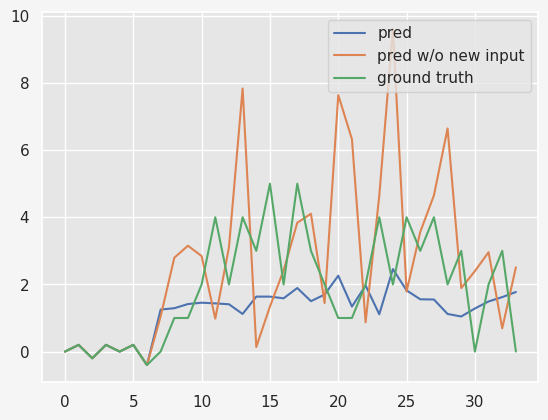

In [528]:
for idx,data in enumerate(test_data_loader):
    x_orig, y =data[0].to(device), data[1].to(device)

sel_id=312
x_history=x_orig[0,sel_id,:].flatten().detach().cpu()
pred_sel=np.append(x_history,pred[:,sel_id].flatten())
pred_ooo_sel=np.append(x_history, pred_ooo[:,sel_id].flatten())
gt_sel=np.append(x_history, gt[:,sel_id].flatten())


plt.plot(pred_sel, label='pred')
plt.plot(pred_ooo_sel, label= 'pred w/o new input')
plt.plot(gt_sel, label= 'ground truth')
plt.legend()
plt.savefig(f'./pred_ooo_{sel_id}.png',bbox_inches='tight')

(-0.5, 639.5, 479.5, -0.5)

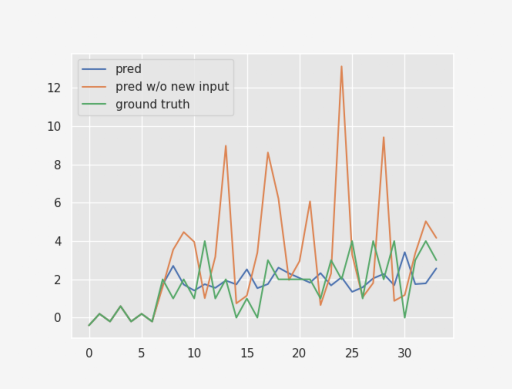

In [529]:
plt.imshow(plt.imread('./pred_ooo_310.png'))
plt.axis('off')

In [475]:
def metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob, model_desc,log=True,result=None):
    mae=mean_absolute_error(gt.reshape(-1), pred.reshape(-1))
    mse=mean_squared_error(gt.reshape(-1), pred.reshape(-1))
    mae_pct=mean_absolute_percentage_error(pred.reshape(-1),gt.reshape(-1) )
    r2=r2_score(gt.reshape(-1), pred.reshape(-1))
    acc=accuracy_score(gt_c.reshape(-1), pred_c.reshape(-1))
    precision=precision_score(gt_c.reshape(-1), pred_c.reshape(-1))
    recall=recall_score(gt_c.reshape(-1), pred_c.reshape(-1))
    f1=f1_score(gt_c.reshape(-1), pred_c.reshape(-1))
    auc=roc_auc_score( gt_c.reshape(-1),pred_c.reshape(-1))
    
    
    res=f'''{model_desc}
test loss: {test_loss:.8f}, 
MAE:{mae},
MSE:{mse},
MAE%:{mae_pct}
R2:{r2},
ACC:{acc},
Precision:{precision},
Recall:{recall},
f1:{f1},
AUC:{auc}

'''
    if log:
        f = open('./results.txt',"a+")
        f.write(res)
    if result is not None and len(result.keys())==0:
        result['MAE']=[mae]
        result['MSE']=[mse]
        result['MAE_pct']=[mae_pct]
        result['R2']=[r2]
        result['Accuracy']=[acc]
        result['Precision']=[precision]
        result['Recall']=[recall]
        result['F1']=[f1]
        result['AUC']=[auc]
        result['desc']=[model_desc]
    elif result is not None:
        result['MAE'].append(mae)
        result['MSE'].append(mse)
        result['MAE_pct'].append(mae_pct)
        result['R2'].append(r2)
        result['Accuracy'].append(acc)
        result['Precision'].append(precision)
        result['Recall'].append(recall)
        result['F1'].append(f1)
        result['AUC'].append(auc)
        result['desc'].append(model_desc)
    print(res)


In [476]:
class BaseModel(torch.nn.Module):

    def __init__(self,mode=3,  hs=32, lstm_layers=2, heads=2,lstm_output=2,K=1) -> None:
        super().__init__()
        self.hs=hs
        self.mode = mode
        self.model_desc=f'Base model mode:{mode}, HS: {self.hs}, lstm_layers={lstm_layers}, GAT heads:{heads}, K:{K}'
        self.lstm_output=lstm_output
        if mode == 0 :
            self.fc0=nn.Linear(SEQ,hs)
        if mode ==1 or mode==3:
            self.lstm=nn.LSTM(1, hs, lstm_layers, batch_first=True,dropout=0.2)
            self.lstm_fc=nn.Linear(hs*self.lstm_output,hs)
#             self.lstm=nn.GRU(1,hs,lstm_layers,batch_first=True,dropout=0.2)
        if mode ==2 or mode ==3:
            self.gnn_network=GATConv(12, 128,heads=heads, concat=False)

        
        if mode == 0:
            self.combined=nn.Linear(hs, hs)
            self.fc=nn.Linear(hs, 1)
            self.fc_classfication=nn.Linear(hs,2)
        elif mode ==1:
            self.combined=nn.Linear(hs, hs)
            self.fc=nn.Linear(hs, 1)
            self.fc_classfication=nn.Linear(hs,2)
        elif mode ==2:
            self.combined=nn.Linear(128, hs)
            self.fc=nn.Linear(hs, 1)
            self.fc_classfication=nn.Linear(hs,2)
        if mode == 3:
            self.combined=GCNConv(hs+128, 128)
            self.combined1=GCNConv(128, hs)
            self.fc=nn.Linear(hs, 1)
            self.fc_classfication=nn.Linear(hs,2)
        
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):#     torch.Size([77, 226, 28]) input training batch 128
        if self.mode == 0 :
            x=self.dropout(F.relu(self.fc0(x)))
        if self. mode ==1 or self.mode==3 :
            x_lstm=x.flatten(0,1).unsqueeze(-1)
            x_lstm,(h,c) =self.lstm(x_lstm)
#             print(x_lstm.shape,h.shape,c.shape)
            
            x_lstm=(x_lstm[:,-self.lstm_output:]) #17402, 32
            x_lstm=x_lstm.reshape(-1,nets.shape[0],  self.hs*self.lstm_output) #77, 226, 32
            x=(self.lstm_fc(F.relu(x_lstm)))

        if self.mode==2 or self.mode==3:
            network=net_fix
            network=self.dropout(F.relu(self.gnn_network(network, edge_index)))
#             network=self.dropout(F.relu(self.gnn_network1(network, edge_index)))
            network=network.repeat(x.shape[0],1,1)
          
        if self.mode==0:
            x=self.dropout(F.relu(self.combined(x)))
        elif self.mode==1:
            x=self.dropout(F.relu(self.combined(x)))
        elif self.mode==2:
            x=self.dropout(F.relu(self.combined(network)))
        elif self.mode==3:
            x=torch.cat(( network, x),dim=-1)
            x=self.dropout(F.relu(self.combined(x, edge_index)))
            x=self.dropout(F.relu(self.combined1(x, edge_index)))
       
            
        x_pred=self.fc(x)
        x_c=F.sigmoid(self.fc_classfication(x))
        return x_pred, x_c


98339
  0 -- train loss: 7.31414961, val loss:7.29926795
 50 -- train loss: 7.02126720, val loss:7.06931260
100 -- train loss: 6.99978904, val loss:7.06144235
Base model mode:3, HS: 32, lstm_layers=2, GAT heads:32, K:1
test loss: 6.96680224, 
MAE:0.3355995714664459,
MSE:0.34407034516334534,
MAE%:1.6119130849838257
R2:0.2874713423133767,
ACC:0.7771027406507358,
Precision:0.47120892372625867,
Recall:0.6838766134325093,
f1:0.5579651941097724,
AUC:0.742561536178011




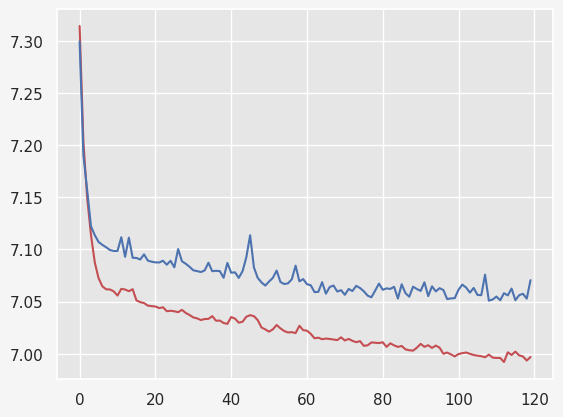

In [464]:
# result={}
for m in [3]:
    MODEL_NAME='base'
    
    model=BaseModel(mode=m,  hs=32, lstm_layers=2, heads=32,lstm_output=3,K=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
    model_desc=model.model_desc
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    # initialize the loss function using mean squared error
    crit=nn.MSELoss(reduction='sum')
    crit_classification=nn.CrossEntropyLoss(reduction='sum')
    history=[]
    val_history=[]
    best_validate_mae = np.inf
    validate_score_non_decrease_count = 0
    best_epoch=0
    for epoch in range(120):
        loss=train(model,train_data_loader,optimizer,crit,crit_classification)

        history.append(loss)
        val_loss,pred,gt,pred_c,gt_c,pred_c_prob=test(model,val_data_loader,crit,crit_classification)
        val_history.append(val_loss)
        if epoch >70 and  val_history[-1]>val_history[-2]+2e-2:
            print('break at: ', epoch)
            break
    #      progress monitor:
        if (epoch) % 50==0:
            print(f'{epoch:3d} -- train loss: {loss:.8f}, val loss:{val_loss:.8f}')
#             metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False)
    test_loss,pred,gt,pred_c,gt_c,pred_c_prob=test(model,test_data_loader,crit,crit_classification)
    metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False,result=None)

#     plt.figure(figsize=(15,5))
#     plt.plot(pred[0,:], label='predicted 0', color='red')
#     plt.plot(gt[0,:], label='real 0', color='blue',alpha=0.5)
#     plt.plot(pred[10,:], label='predicted 10', color='orange')
#     plt.plot(gt[10,:], label='real 10', color='g',alpha=0.5)
#     plt.legend(loc='best')
#     plt.title(f'Predicted vs Real {MODEL_NAME},SEQ={SEQ}, test loss: {test_loss:.4f}')
#     plt.show()
    plt.plot(history[:],c='r')
    plt.plot(val_history[:],c='b')
    plt.show()

#     fig, axs = plt.subplots(1, 3, figsize=(16,5))
#     axs = np.ravel(axs)
#     sel_idx=0
#     nets['y']=gt[sel_idx,:]
#     nets.plot(column='y',legend=True, ax=axs[0],edgecolor='none')

#     nets['y']=pred[sel_idx,:]
#     nets.plot(column='y',legend=True, ax=axs[1],edgecolor='none')

#     nets['y']=pred_c[sel_idx,:]
#     nets.plot(column='y',legend=True, ax=axs[2],edgecolor='none')
#     axs[0].set_title('GT')
#     axs[1].set_title('PRED')
#     axs[2].set_title('PRED classficatiokn')
#     plt.show()

In [488]:
# nets.plot()
# plt.title('D.C. partition')
# plt.xlabel('long')
# plt.ylabel('lat')
# plt.savefig('./nets.png',dpi=300,bbox_inches='tight')
nets.shape

(823, 3)

97315
  0 -- train loss: 7.30049901, val loss:7.26071252
 70 -- train loss: 7.03934176, val loss:7.11354625
140 -- train loss: 6.99604256, val loss:7.10660471
Base model mode:3, HS: 32, lstm_layers=2, GAT heads:32, K:4
test loss: 6.98966842, 
MAE:0.36676517128944397,
MSE:0.3714311718940735,
MAE%:1.3773422241210938
R2:0.2769919687567408,
ACC:0.7625219387066289,
Precision:0.46572447497028135,
Recall:0.741067675493905,
f1:0.5719847513991402,
AUC:0.7547175404326307




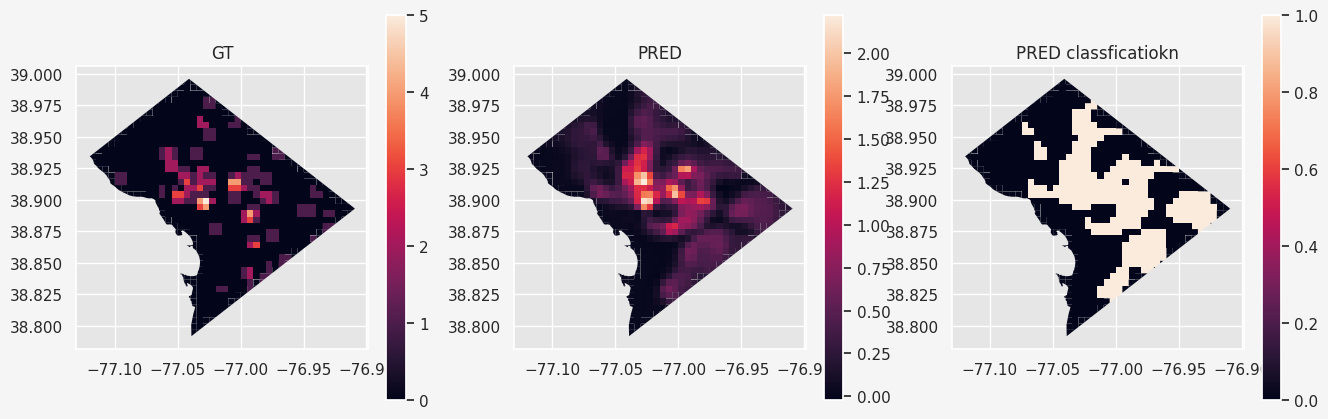

In [507]:
# column 0 is geoinfo, column 1 is index, need to be removed
# for t in ['floor','ceil','round']:
result={}
for s in [0]:
#     nets, net_fix, edge_index,_=create_network(0.01)
    t='round'
    # get the Jan data
    jan_crimes=crime_data[(crime_data['start_date'])<'2023-10-01']
#     jan_crimes=jan_crimes.loc[
#                             (jan_crimes.offense=='BURGLARY')
#         (jan_crimes.offense=='ROBBERY')
#                               (jan_crimes.offense=='MOTOR VEHICLE THEFT')
#                               (jan_crimes.offense=='THEFT F/AUTO')|
#                               (jan_crimes.offense=='THEFT/OTHER')
#                               (jan_crimes.offense=='ASSAULT W/WEAPON ')
                             
#                              ]  #ROBBERY BURGLARY
#     jan_crimes=jan_crimes.loc[jan_crimes.offense_group == 'property'] # property, violent

    buffer_length_in_meters = 0.002 #0.002/0.005 the best
    jan_crimes.geometry=jan_crimes.buffer(buffer_length_in_meters)


    temp=gpd.sjoin(jan_crimes.iloc[:,1:], nets,how='left', op='intersects')
    if t=='floor':
        temp['date']=temp['start_date'].dt.floor(freq=f'24h')
    elif t=='ceil':
        temp['date']=temp['start_date'].dt.ceil(freq=f'24h')
    elif t=='round':
        temp['date']=temp['start_date'].dt.round(freq=f'24h')
    
    sel_temp=temp[['date','index','location']]
    pt=sel_temp.pivot_table(index='date',columns=['index'],aggfunc='count',values='location',fill_value=0)

    ts=nets.drop('y',axis=1)
    for ids, row in pt.iterrows():
        tt=nets.merge(row,left_on='index',right_on='index',how='left')
        ts[ids]=tt.iloc[:,-1]
    ts=ts.fillna(0)
    
    SEQ=7
    X=[]
    y=[]
    y_c=[]
    for i in range(ts.shape[1]-SEQ-3):
        i=i+2 # skip index and geo column
        t=ts.iloc[:,i:i+SEQ].values
        t_next=ts.iloc[:,i+1:i+1+SEQ].values
        X.append((t_next-t)/5.0)
        y.append(ts.iloc[:,i+SEQ+1:i+SEQ+2].values)   
        y_c.append(np.hstack((ts.iloc[:,i+SEQ:i+SEQ+1].values<=0,ts.iloc[:,i+SEQ:i+SEQ+1].values>0)))   
    X=np.array(X)
    y=np.array(y)
    y_c=np.array(y_c).astype(float)
    X.shape

    # Split in train-test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=0)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=False, random_state=0)
    train_size=Y_train.shape[0]
    val_size=Y_val.shape[0]
    test_size=Y_test.shape[0]

    # transform to torch dataset
    X_train = torch.from_numpy(X_train).float()
    Y_train = torch.from_numpy(Y_train).float()
    X_val = torch.from_numpy(X_val).float()
    Y_val = torch.from_numpy(Y_val).float()
    X_test = torch.from_numpy(X_test).float()
    Y_test = torch.from_numpy(Y_test).float()
    train_tensor = torch.utils.data.TensorDataset(X_train, Y_train) 
    val_tensor = torch.utils.data.TensorDataset(X_val, Y_val) 
    test_tensor = torch.utils.data.TensorDataset(X_test, Y_test) 
    train_data_loader = torch.utils.data.DataLoader(train_tensor, batch_size=32,shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_tensor, batch_size=128,shuffle=False)
    test_data_loader = torch.utils.data.DataLoader(test_tensor, batch_size=128,shuffle=False)

# net_fix=torch.from_numpy(net_fix.values).float()


    MODEL_NAME='base'
    model=BaseModel(mode=3,  hs=32, lstm_layers=2, heads=32,K=4).to(device)
    model_desc=model.model_desc
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
    # initialize the loss function using mean squared error
    crit=nn.MSELoss(reduction='sum')
    crit_classification=nn.CrossEntropyLoss(reduction='sum')
    history=[]
    val_history=[]
    best_validate_mae = np.inf
    validate_score_non_decrease_count = 0
    best_epoch=0
    for epoch in range(150):
        loss=train(model,train_data_loader,optimizer,crit,crit_classification)

        history.append(loss)
        val_loss,pred,gt,pred_c,gt_c,pred_c_prob=test(model,val_data_loader,crit,crit_classification)
        val_history.append(val_loss)
    #      progress monitor:
        if (epoch) % 70==0:
            print(f'{epoch:3d} -- train loss: {loss:.8f}, val loss:{val_loss:.8f}')
#             metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False,result=result)
    test_loss,pred,gt,pred_c,gt_c,pred_c_prob=test(model,test_data_loader,crit,crit_classification)
    metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False, result=result)
    
    fig, axs = plt.subplots(1, 3, figsize=(16,5))
    axs = np.ravel(axs)
    sel_idx=0
    nets['y']=gt[sel_idx,:]
    nets.plot(column='y',legend=True, ax=axs[0],edgecolor='none')

    nets['y']=pred[sel_idx,:]
    nets.plot(column='y',legend=True, ax=axs[1],edgecolor='none')

    nets['y']=pred_c[sel_idx,:]
    nets.plot(column='y',legend=True, ax=axs[2],edgecolor='none')
    axs[0].set_title('GT')
    axs[1].set_title('PRED')
    axs[2].set_title('PRED classficatiokn')
    plt.show()

In [509]:
torch.save(model, './models/stgnn.pt')

In [505]:
result_df=pd.DataFrame(result)
result_df.shape
result_df[0:5].describe()

,MAE,MSE,MAE_pct,R2,Accuracy,Precision,Recall,F1,AUC
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.062564,0.036616,2.110136,0.015765,0.740948,0.077819,0.703323,0.139729,0.722713
std,0.005944,0.000282,0.650729,0.007589,0.042064,0.003945,0.095702,0.004043,0.024907
min,0.058299,0.036339,1.594463,0.004855,0.704289,0.073727,0.539275,0.134598,0.679745
25%,0.058322,0.036401,1.896971,0.011450,0.719545,0.076456,0.700906,0.138622,0.722943
50%,0.058689,0.036541,1.902788,0.017782,0.725395,0.076748,0.741692,0.139464,0.733293
75%,0.066161,0.036776,1.906955,0.021524,0.743666,0.077826,0.762840,0.140097,0.737058
max,0.071349,0.037022,3.249504,0.023216,0.811845,0.084337,0.771903,0.145863,0.740528


In [368]:
# result={}
for m in [ 0]:
    MODEL_NAME='base'
    
    model=BaseModel(mode=m,  hs=32, lstm_layers=2, heads=32,lstm_output=3,K=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
    model_desc=model.model_desc
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    # initialize the loss function using mean squared error
    crit=nn.MSELoss(reduction='sum')
    crit_classification=nn.CrossEntropyLoss(reduction='sum')
    history=[]
    val_history=[]
    best_validate_mae = np.inf
    validate_score_non_decrease_count = 0
    best_epoch=0
    for epoch in range(120):
        loss=train(model,train_data_loader,optimizer,crit,crit_classification)

        history.append(loss)
        val_loss,pred,gt,pred_c,gt_c,pred_c_prob=test(model,val_data_loader,crit,crit_classification)
        val_history.append(val_loss)
        if epoch >70 and  val_history[-1]>val_history[-2]+2e-2:
            print('break at: ', epoch)
            break
    #      progress monitor:
        if (epoch) % 50==0:
            print(f'{epoch:3d} -- train loss: {loss:.8f}, val loss:{val_loss:.8f}')
#             metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False)
    test_loss_m0,pred_m0,gt,pred_c,gt_c,pred_c_prob=test(model,test_data_loader,crit,crit_classification)
#     metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False,result=result)



1411
  0 -- train loss: 7.27181628, val loss:7.22188655
 50 -- train loss: 7.03965409, val loss:7.07940968
100 -- train loss: 7.03801773, val loss:7.08066509


In [369]:
# result={}
for m in [ 1]:
    MODEL_NAME='base'
    
    model=BaseModel(mode=m,  hs=32, lstm_layers=2, heads=32,lstm_output=3,K=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
    model_desc=model.model_desc
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    # initialize the loss function using mean squared error
    crit=nn.MSELoss(reduction='sum')
    crit_classification=nn.CrossEntropyLoss(reduction='sum')
    history=[]
    val_history=[]
    best_validate_mae = np.inf
    validate_score_non_decrease_count = 0
    best_epoch=0
    for epoch in range(120):
        loss=train(model,train_data_loader,optimizer,crit,crit_classification)

        history.append(loss)
        val_loss,pred,gt,pred_c,gt_c,pred_c_prob=test(model,val_data_loader,crit,crit_classification)
        val_history.append(val_loss)
        if epoch >70 and  val_history[-1]>val_history[-2]+2e-2:
            print('break at: ', epoch)
            break
    #      progress monitor:
        if (epoch) % 50==0:
            print(f'{epoch:3d} -- train loss: {loss:.8f}, val loss:{val_loss:.8f}')
#             metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False)
    test_loss_m1,pred_m1,gt,pred_c,gt_c,pred_c_prob=test(model,test_data_loader,crit,crit_classification)
#     metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False,result=result)



17187
  0 -- train loss: 7.32989312, val loss:7.36141751
 50 -- train loss: 7.03999557, val loss:7.08338396
100 -- train loss: 7.03805181, val loss:7.08405399


In [408]:
# result={}
for m in [2]:
    MODEL_NAME='base'
    
    model=BaseModel(mode=m,  hs=32, lstm_layers=2, heads=32,lstm_output=3,K=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
    model_desc=model.model_desc
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    # initialize the loss function using mean squared error
    crit=nn.MSELoss(reduction='sum')
    crit_classification=nn.CrossEntropyLoss(reduction='sum')
    history=[]
    val_history=[]
    best_validate_mae = np.inf
    validate_score_non_decrease_count = 0
    best_epoch=0
    for epoch in range(120):
        loss=train(model,train_data_loader,optimizer,crit,crit_classification)

        history.append(loss)
        val_loss,pred,gt,pred_c,gt_c,pred_c_prob=test(model,val_data_loader,crit,crit_classification)
        val_history.append(val_loss)
        if epoch >70 and  val_history[-1]>val_history[-2]+2e-2:
            print('break at: ', epoch)
            break
    #      progress monitor:
        if (epoch) % 50==0:
            print(f'{epoch:3d} -- train loss: {loss:.8f}, val loss:{val_loss:.8f}')
#             metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False)
    test_loss_m2,pred_m2,gt,pred_c,gt_c,pred_c_prob=test(model,test_data_loader,crit,crit_classification)
#     metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False,result=result)



61699
  0 -- train loss: 7.25083182, val loss:7.16797143
 50 -- train loss: 7.02667195, val loss:7.03948389
100 -- train loss: 7.01576357, val loss:7.01248250


In [430]:
# result={}
for m in [3]:
    MODEL_NAME='base'
    
    model=BaseModel(mode=m,  hs=32, lstm_layers=2, heads=32,lstm_output=3,K=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
    model_desc=model.model_desc
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    # initialize the loss function using mean squared error
    crit=nn.MSELoss(reduction='sum')
    crit_classification=nn.CrossEntropyLoss(reduction='sum')
    history=[]
    val_history=[]
    best_validate_mae = np.inf
    validate_score_non_decrease_count = 0
    best_epoch=0
    for epoch in range(120):
        loss=train(model,train_data_loader,optimizer,crit,crit_classification)

        history.append(loss)
        val_loss,pred,gt,pred_c,gt_c,pred_c_prob=test(model,val_data_loader,crit,crit_classification)
        val_history.append(val_loss)
        if epoch >70 and  val_history[-1]>val_history[-2]+2e-2:
            print('break at: ', epoch)
            break
    #      progress monitor:
        if (epoch) % 50==0:
            print(f'{epoch:3d} -- train loss: {loss:.8f}, val loss:{val_loss:.8f}')
#             metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False)
    test_loss_m3,pred_m3,gt,pred_c,gt_c,pred_c_prob=test(model,test_data_loader,crit,crit_classification)
    metrics(test_loss_m3,pred_m3,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False,result=None)



135459
  0 -- train loss: 7.44998906, val loss:7.28007951
 50 -- train loss: 7.00280184, val loss:7.01104621
100 -- train loss: 6.98906063, val loss:7.00885133
Base model mode:3, HS: 32, lstm_layers=2, GAT heads:32, K:3
test loss: 6.95482493, 
MAE:0.3406044542789459,
MSE:0.33651673793792725,
MAE%:1.6395156383514404
R2:0.3066446858383046,
ACC:0.7718945695859426,
Precision:0.4663136216534275,
Recall:0.7167081166628985,
f1:0.5650120310132787,
AUC:0.7514910244581061




In [414]:
daily_mse_m0=[]
daily_mse_m1=[]
daily_mse_m2=[]
daily_mse_m3=[]
for i in range (gt.shape[0]):
    gt_1=gt[i].flatten()
    
    pred_1=pred_m3[i].flatten()
    mse_1=mean_squared_error(gt_1,pred_1)
    daily_mse_m3.append(mse_1)
    
    pred_1=pred_m0[i].flatten()
    mse_1=mean_squared_error(gt_1,pred_1)
    daily_mse_m0.append(mse_1)
    
    pred_1=pred_m1[i].flatten()
    mse_1=mean_squared_error(gt_1,pred_1)
    daily_mse_m1.append(mse_1)
    
    pred_1=pred_m2[i].flatten()
    mse_1=mean_squared_error(gt_1,pred_1)
    daily_mse_m2.append(mse_1)
    
    

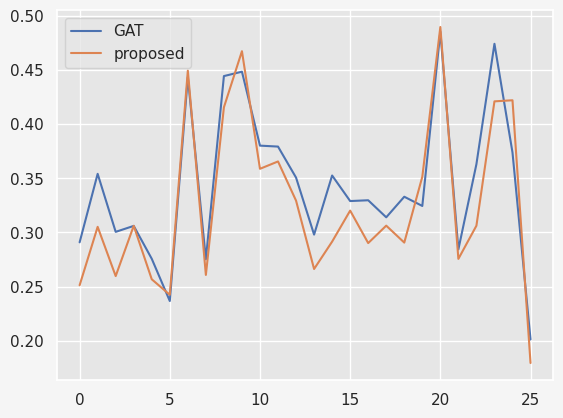

In [415]:
# plt.plot(daily_mse_m0, label='MLP')
# plt.plot(daily_mse_m1, label='LSTM')
plt.plot(daily_mse_m2, label='GAT')
plt.plot(daily_mse_m3, label='proposed')
plt.legend()

In [498]:
result_df=pd.DataFrame(result)
result_df.shape
result_df[0:5].describe()

(5, 10)

In [499]:
result_df[0:5].describe()

,MAE,MSE,MAE_pct,R2,Accuracy,Precision,Recall,F1,AUC
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.263453,0.244026,23.601164,0.165386,0.810567,0.398149,0.621234,0.485198,0.731786
std,0.010669,0.015024,48.826569,0.051386,0.003690,0.005541,0.010791,0.002251,0.002769
min,0.250230,0.228256,1.352955,0.083389,0.807974,0.393283,0.603194,0.481216,0.728074
25%,0.259145,0.236024,1.451253,0.156237,0.808739,0.396026,0.619793,0.485718,0.729673
50%,0.263668,0.241148,1.950877,0.175228,0.809460,0.396829,0.625744,0.486040,0.733095
75%,0.264630,0.246701,2.308688,0.192755,0.809595,0.396901,0.626997,0.486467,0.733537
max,0.279592,0.268000,110.942047,0.219322,0.817065,0.407705,0.630442,0.486548,0.734550


In [419]:
result_df[5:10].describe()

,MAE,MSE,MAE_pct,R2,Accuracy,Precision,Recall,F1,AUC
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.346542,0.337862,1.598049,0.303873,0.770960,0.464853,0.704680,0.559870,0.746455
std,0.013407,0.003301,0.393331,0.006800,0.008037,0.010853,0.021395,0.001710,0.003011
min,0.334158,0.334553,1.283194,0.294931,0.759136,0.449496,0.676916,0.557976,0.742847
25%,0.334634,0.335961,1.332072,0.298415,0.769418,0.462465,0.697264,0.558089,0.744214
50%,0.343529,0.336084,1.510255,0.307536,0.771754,0.465229,0.702012,0.560641,0.746735
75%,0.355612,0.340511,1.602422,0.307790,0.772969,0.467269,0.711734,0.561077,0.748091
max,0.364776,0.342202,2.262303,0.310691,0.781522,0.479808,0.735474,0.561568,0.750388


In [420]:
result_df[10:15].describe()

,MAE,MSE,MAE_pct,R2,Accuracy,Precision,Recall,F1,AUC
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.353238,0.342536,1.519244,0.294243,0.754360,0.447659,0.758173,0.560848,0.755770
std,0.018332,0.007010,0.339719,0.014444,0.022108,0.027757,0.058649,0.003844,0.007954
min,0.327887,0.335318,1.211403,0.276182,0.736658,0.426935,0.661768,0.556848,0.742489
25%,0.341873,0.335350,1.302622,0.287991,0.738247,0.428311,0.742709,0.556892,0.754447
50%,0.360129,0.345140,1.319284,0.288877,0.745724,0.436439,0.790188,0.562304,0.759456
75%,0.361822,0.345570,1.787735,0.309049,0.761333,0.452854,0.795614,0.562645,0.760294
max,0.374479,0.351302,1.975176,0.309114,0.789840,0.493758,0.800588,0.565549,0.762163


In [421]:
result_df[15:20].describe()

,MAE,MSE,MAE_pct,R2,Accuracy,Precision,Recall,F1,AUC
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.352207,0.337301,1.468689,0.305029,0.767044,0.460880,0.732444,0.565316,0.754251
std,0.012605,0.006951,0.334657,0.014322,0.011690,0.014928,0.023757,0.004522,0.001729
min,0.342477,0.330843,1.230028,0.288202,0.751425,0.441560,0.710604,0.560013,0.752150
25%,0.342896,0.331597,1.282371,0.291211,0.758482,0.449505,0.717612,0.562034,0.753151
50%,0.344162,0.334589,1.366223,0.310617,0.771614,0.466002,0.718969,0.565484,0.754153
75%,0.362388,0.344007,1.410923,0.316782,0.773998,0.469457,0.749717,0.567597,0.755242
max,0.369114,0.345468,2.053899,0.318335,0.779699,0.477877,0.765318,0.571455,0.756562


In [347]:
result_df[20:25].describe()

,MAE,MSE,MAE_pct,R2,Accuracy,Precision,Recall,F1,AUC
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.349247,0.338449,1.415828,0.299112,0.762693,0.455042,0.745089,0.563991,0.756170
std,0.020373,0.011813,0.222220,0.024463,0.018498,0.022318,0.037018,0.007045,0.002330
min,0.331648,0.329317,1.175541,0.257338,0.737321,0.426034,0.709692,0.555412,0.754017
25%,0.335166,0.330788,1.294265,0.299893,0.751136,0.439905,0.716473,0.559363,0.754526
50%,0.344908,0.335448,1.346691,0.305327,0.765942,0.457073,0.733756,0.563271,0.755299
75%,0.351688,0.338072,1.514367,0.314978,0.776923,0.472174,0.767884,0.569219,0.757342
max,0.382825,0.358621,1.748277,0.318024,0.782143,0.480024,0.797637,0.572690,0.759668


4931
  0 -- train loss: 100.40370058, val loss:145.05462325
 50 -- train loss: 99.25400687, val loss:143.40794613
break at:  76
Base model mode:0, HS: 64, gnn:GCN, lstm_layers=2, GAT heads:32, K:2
test loss: 129.67697870, 
MAE:0.4084928631782532,
MSE:0.5113131999969482,
MAE%:1.932831883430481
R2:0.33083607893292566,
ACC:0.7273042874500955,
Precision:0.45640582216457704,
Recall:0.7709347614410905,
f1:0.5733683352946501,
AUC:0.7423174755972056




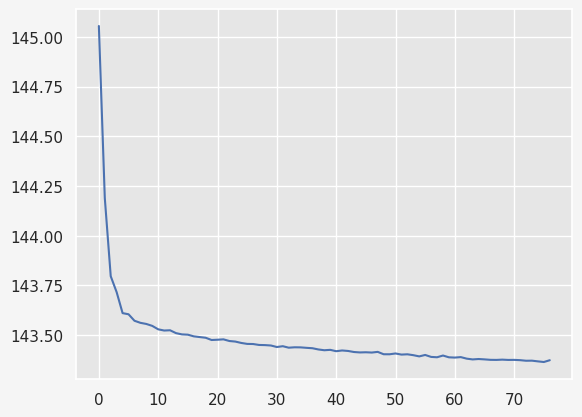

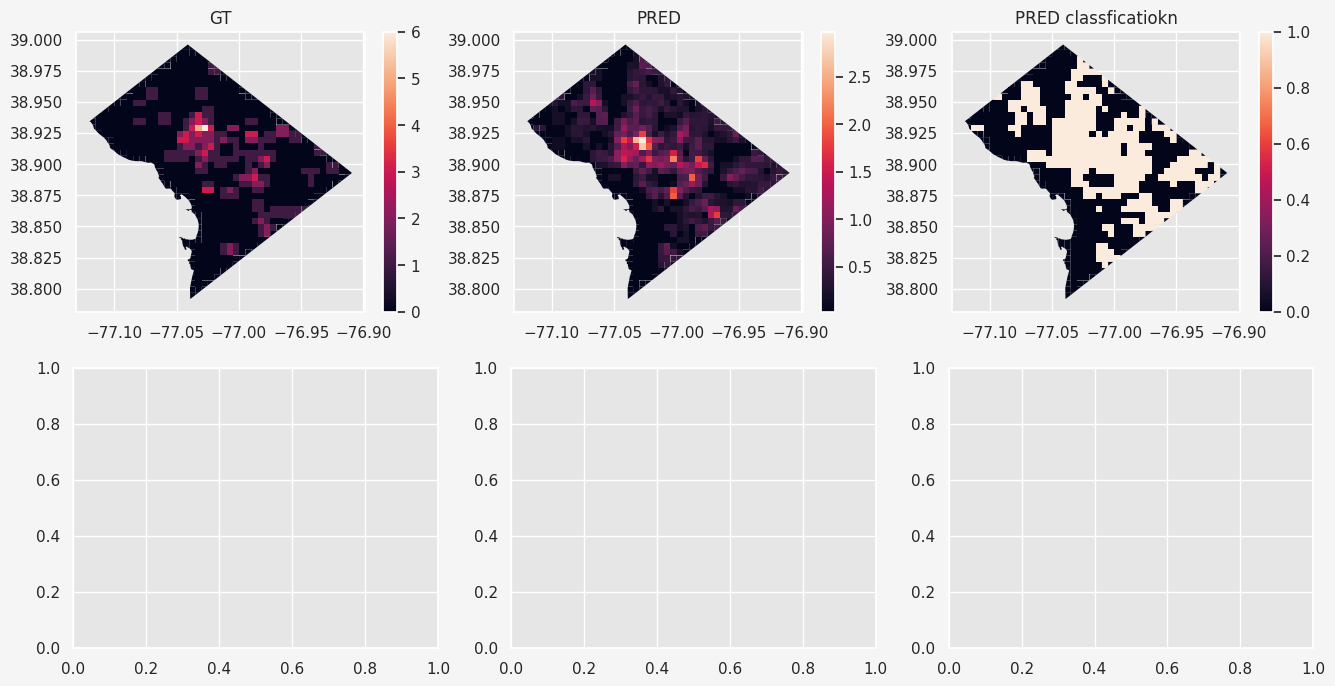

71235
  0 -- train loss: 100.47203036, val loss:145.42713045
 50 -- train loss: 99.22028143, val loss:143.34276059
break at:  62
Base model mode:1, HS: 64, gnn:GCN, lstm_layers=2, GAT heads:32, K:2
test loss: 129.63026646, 
MAE:0.42523467540740967,
MSE:0.5965774655342102,
MAE%:1.5861642360687256
R2:0.21924939203183214,
ACC:0.75785453914251,
Precision:0.4934199282173987,
Recall:0.7027750730282376,
f1:0.5797770860528165,
AUC:0.73890176801317




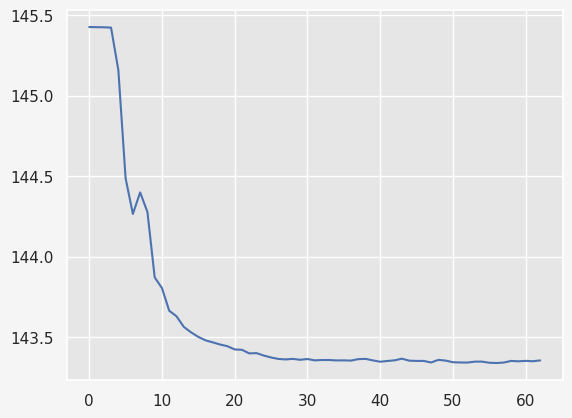

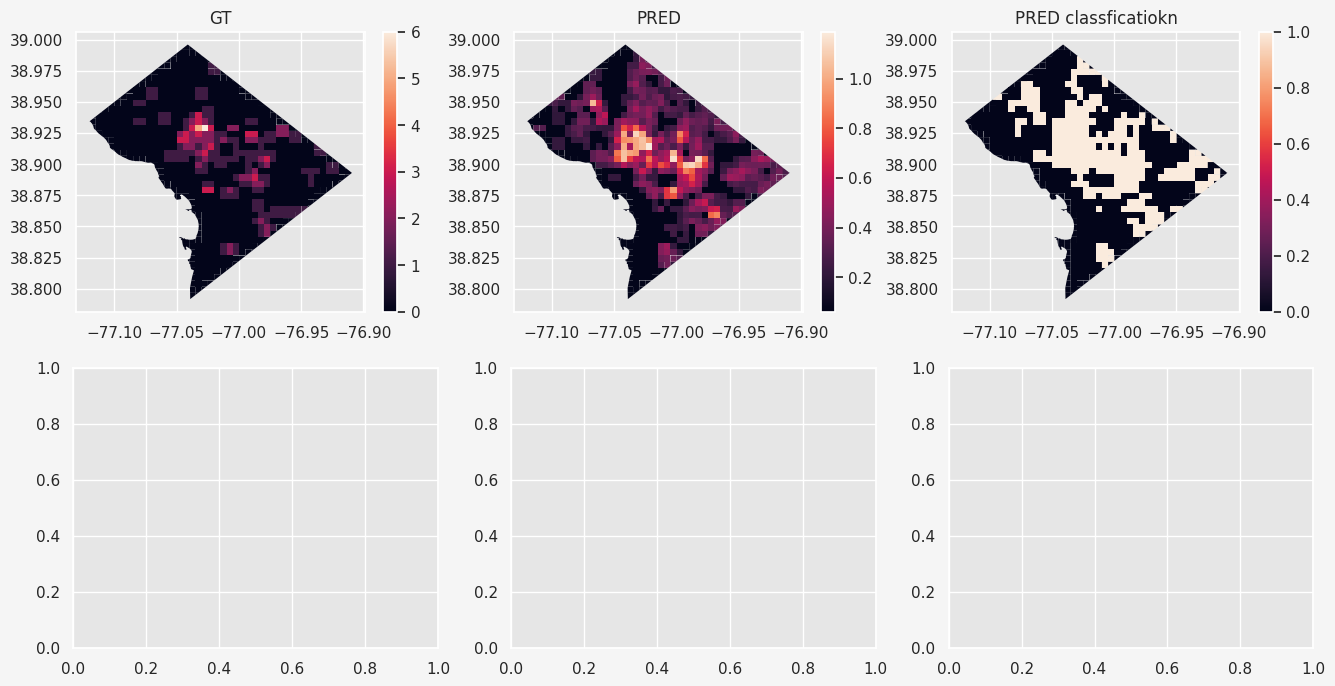

65923
  0 -- train loss: 100.17115885, val loss:144.52523643
 50 -- train loss: 99.08931404, val loss:143.21746505
break at:  66
Base model mode:2, HS: 64, gnn:GCN, lstm_layers=2, GAT heads:32, K:2
test loss: 129.45543852, 
MAE:0.4053357243537903,
MSE:0.554575502872467,
MAE%:17.807296752929688
R2:0.2742180689533533,
ACC:0.7667071688942891,
Precision:0.5064167510976022,
Recall:0.7300389483933788,
f1:0.5980059820538385,
AUC:0.7540896829253422




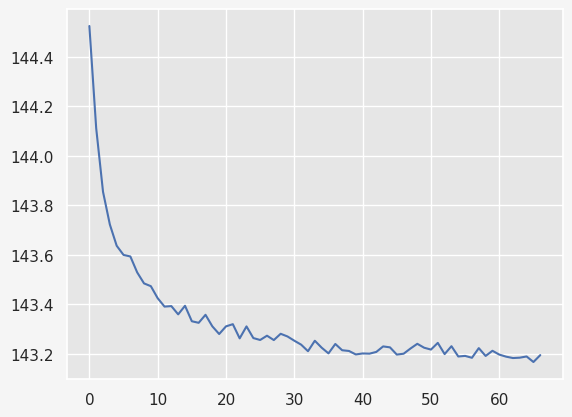

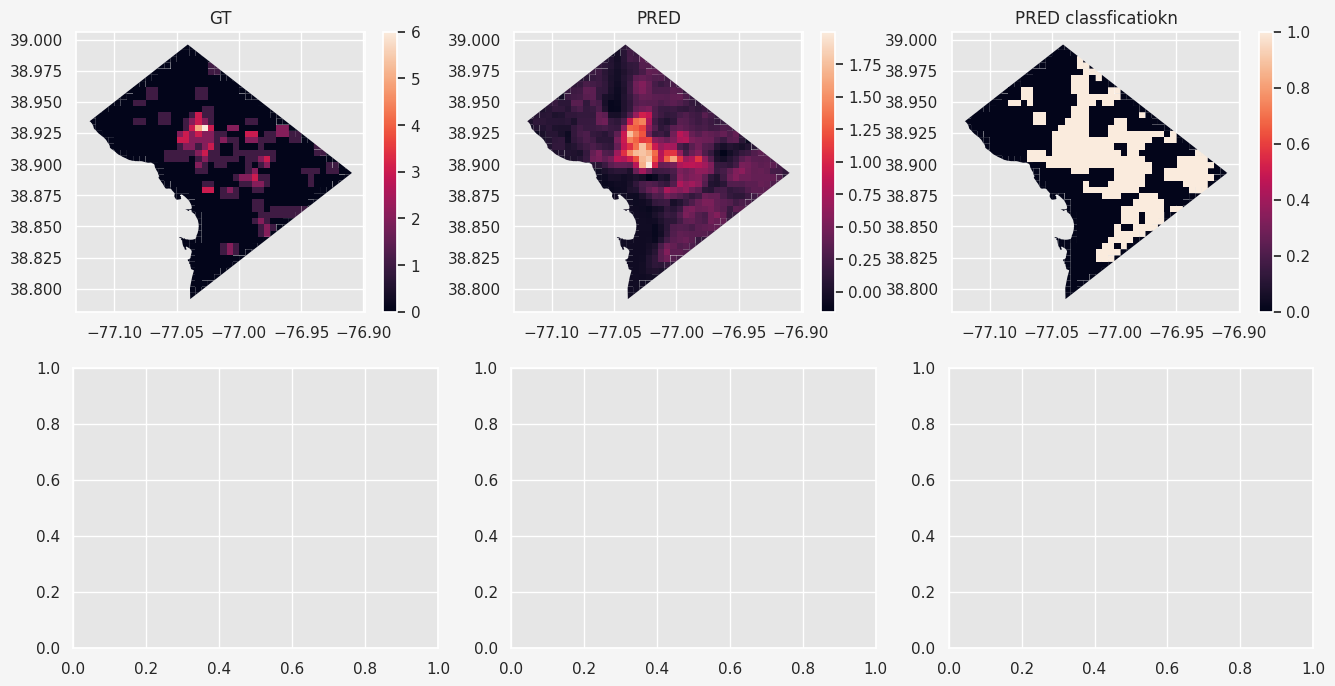

82883
  0 -- train loss: 99.98578510, val loss:144.09439248
 50 -- train loss: 99.06107215, val loss:143.17805561
break at:  62
Base model mode:3, HS: 64, gnn:GCN, lstm_layers=2, GAT heads:32, K:2
test loss: 129.44470796, 
MAE:0.3966221809387207,
MSE:0.5341843366622925,
MAE%:1.7031804323196411
R2:0.30090425058829817,
ACC:0.7792049991320952,
Precision:0.5267203513909224,
Recall:0.7005842259006816,
f1:0.6013372335979942,
AUC:0.7521516954930353




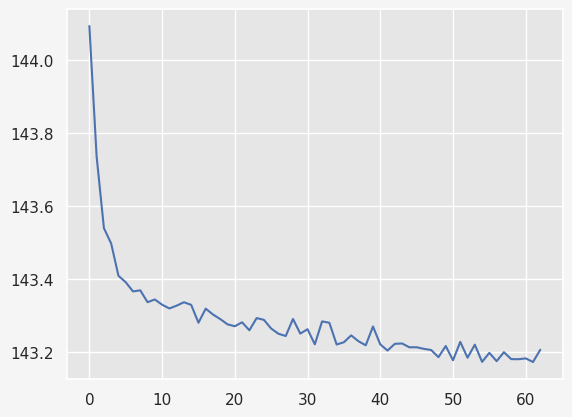

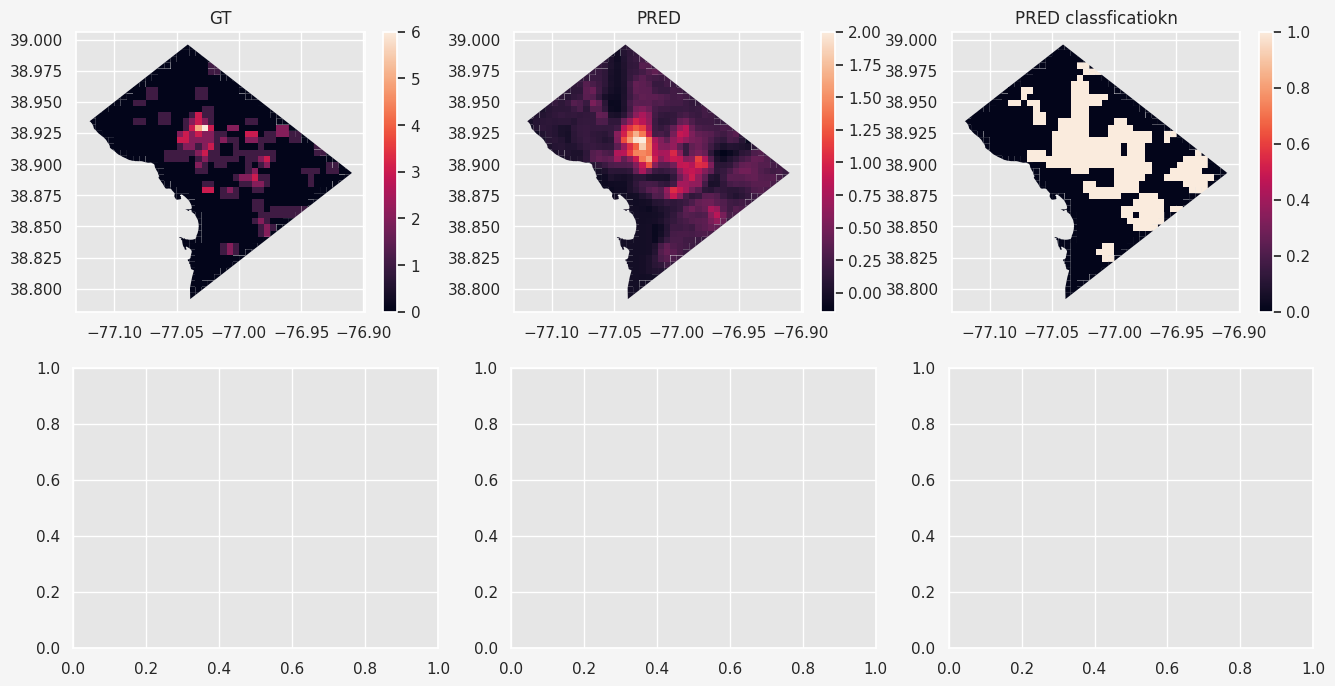

In [146]:
for m in [0,1,2,3]:
    MODEL_NAME='base'
    
    model=BaseModel(mode=m, gnn='GCN', hs=64, lstm_layers=2, heads=32,lstm_output=4,K=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
    model_desc=model.model_desc
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    # initialize the loss function using mean squared error
    crit=nn.MSELoss()
    crit_classification=nn.CrossEntropyLoss()
    history=[]
    val_history=[]
    best_validate_mae = np.inf
    validate_score_non_decrease_count = 0
    best_epoch=0
    for epoch in range(101):
        loss=train(model,train_data_loader,optimizer,crit,crit_classification)

        history.append(loss)
        val_loss,pred,gt,pred_c,gt_c,pred_c_prob=test(model,val_data_loader,crit,crit_classification)
        val_history.append(val_loss)
        if epoch >60 and  val_history[-1]>val_history[-2]+5e-3:
            print('break at: ', epoch)
            break
    #      progress monitor:
        if (epoch) % 50==0:
            print(f'{epoch:3d} -- train loss: {loss:.8f}, val loss:{val_loss:.8f}')
#             metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False)
    test_loss,pred,gt,pred_c,gt_c,pred_c_prob=test(model,test_data_loader,crit,crit_classification)
    metrics(test_loss,pred,gt, pred_c,gt_c,pred_c_prob,model_desc,log=False)

#     plt.figure(figsize=(15,5))
#     plt.plot(pred[0,:], label='predicted 0', color='red')
#     plt.plot(gt[0,:], label='real 0', color='blue',alpha=0.5)
#     plt.plot(pred[10,:], label='predicted 10', color='orange')
#     plt.plot(gt[10,:], label='real 10', color='g',alpha=0.5)
#     plt.legend(loc='best')
#     plt.title(f'Predicted vs Real {MODEL_NAME},SEQ={SEQ}, test loss: {test_loss:.4f}')
#     plt.show()
#     plt.plot(history[:],c='r')
    plt.plot(val_history[:],c='b')
    plt.show()

    fig, axs = plt.subplots(2, 3, figsize=(16,8))
    axs = np.ravel(axs)
    sel_idx=0
    nets['y']=gt[sel_idx,:]
    nets.plot(column='y',legend=True, ax=axs[0],edgecolor='none')

    nets['y']=pred[sel_idx,:]
    nets.plot(column='y',legend=True, ax=axs[1],edgecolor='none')

    nets['y']=pred_c[sel_idx,:]
    nets.plot(column='y',legend=True, ax=axs[2],edgecolor='none')
    axs[0].set_title('GT')
    axs[1].set_title('PRED')
    axs[2].set_title('PRED classficatiokn')
    plt.show()

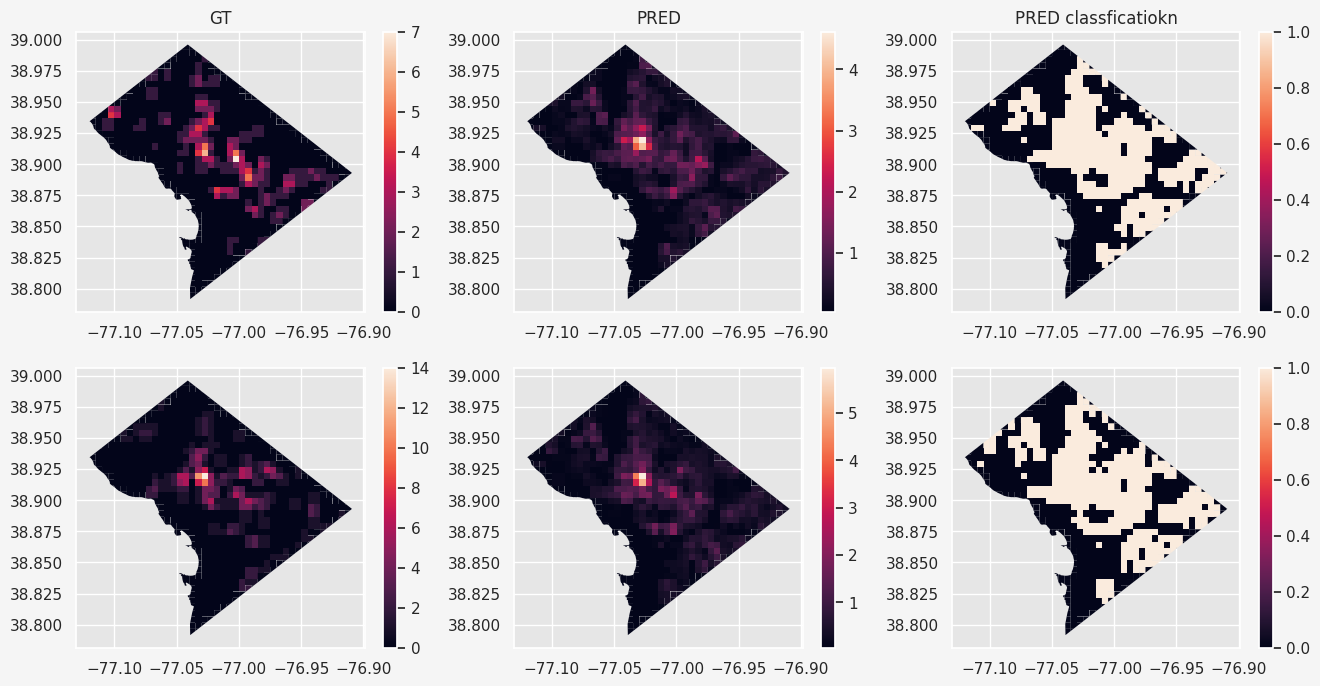

In [140]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
axs = np.ravel(axs)
sel_idx=0
nets['y']=gt[sel_idx,:]
nets.plot(column='y',legend=True, ax=axs[0],edgecolor='none')

nets['y']=pred[sel_idx,:]
nets.plot(column='y',legend=True, ax=axs[1],edgecolor='none')

nets['y']=pred_c[sel_idx,:]
nets.plot(column='y',legend=True, ax=axs[2],edgecolor='none')

nets['y']=gt[sel_idx+2,:]
nets.plot(column='y',legend=True, ax=axs[3],edgecolor='none')

nets['y']=pred[sel_idx+2,:]
nets.plot(column='y',legend=True, ax=axs[4],edgecolor='none')

nets['y']=pred_c[sel_idx+2,:]
nets.plot(column='y',legend=True, ax=axs[5],edgecolor='none')

axs[0].set_title('GT')
axs[1].set_title('PRED')
axs[2].set_title('PRED classficatiokn')
plt.show()

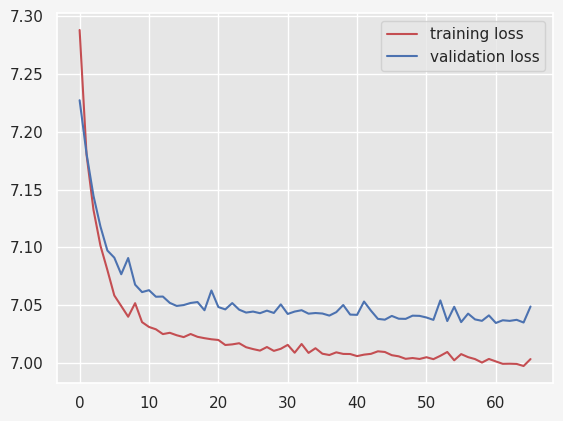

In [259]:
plt.plot(history[:],c='r',label='training loss')
plt.plot(val_history[:],c='b', label='validation loss')
plt.legend()
plt.show()

<Axes: >

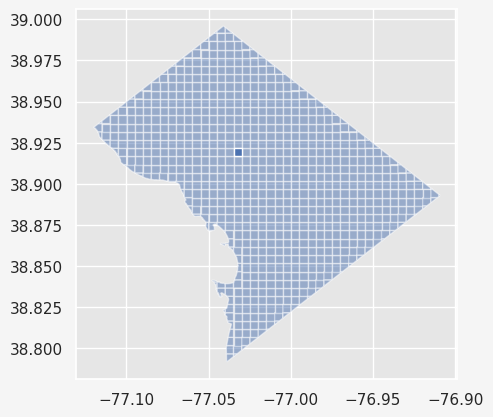

In [176]:
ax=nets.plot(aspect='equal',edgecolor='white',alpha=0.5)
nets.iloc[310:311,0].plot(ax=ax,)

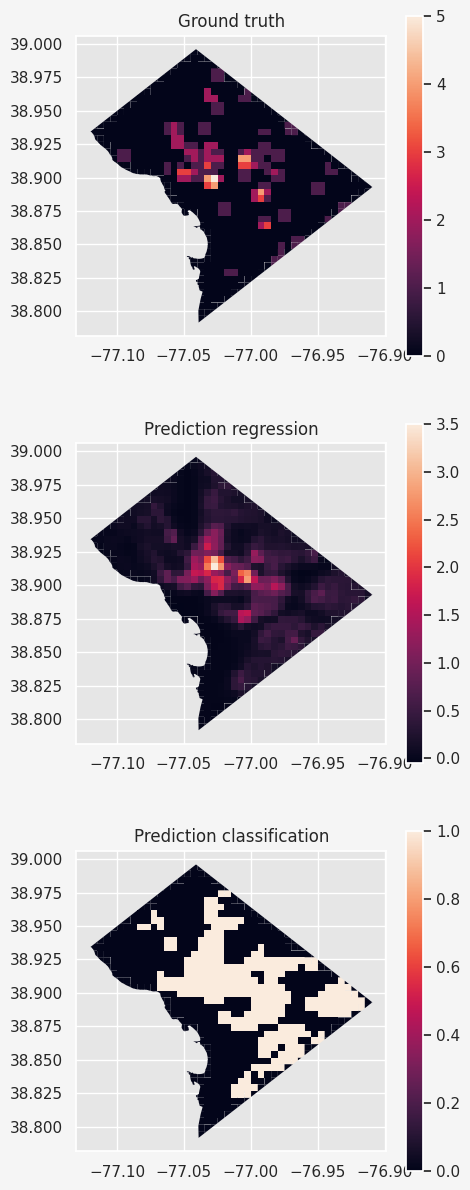

In [451]:
fig, axs = plt.subplots(3, 1, figsize=(5,15))
axs = np.ravel(axs)
sel_idx=0
nets['y']=gt[sel_idx,:]
nets.plot(column='y',legend=True, ax=axs[0],edgecolor='none')

nets['y']=pred[sel_idx,:]
nets.plot(column='y',legend=True, ax=axs[1],edgecolor='none')

nets['y']=pred_c[sel_idx,:]
nets.plot(column='y',legend=True, ax=axs[2],edgecolor='none')
axs[0].set_title('Ground truth')
axs[1].set_title('Prediction regression')
axs[2].set_title('Prediction classification')
plt.show()

In [272]:
ts.iloc[:,3]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
818    0.0
819    0.0
820    0.0
821    0.0
822    0.0
Name: 2023-01-02 00:00:00, Length: 823, dtype: float64

# model selection

In [1604]:
torch.cuda.empty_cache()

Text(0.5, 1.0, 'PRED classficatiokn')

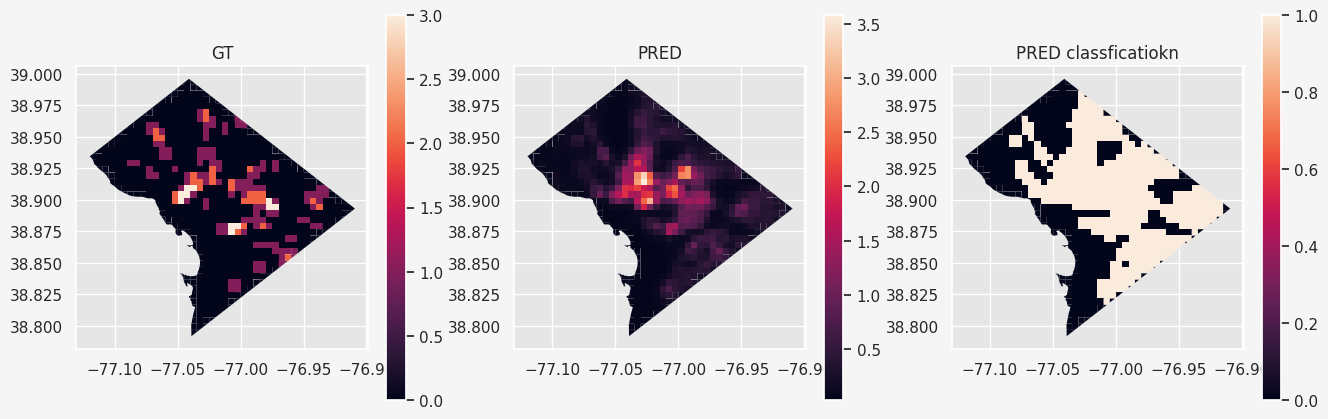

In [354]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))
axs = np.ravel(axs)
sel_idx=1
nets['y']=gt[sel_idx,:]
nets.plot(column='y',legend=True, ax=axs[0],edgecolor='none')

nets['y']=pred[sel_idx,:]
nets.plot(column='y',legend=True, ax=axs[1],edgecolor='none')

nets['y']=pred_c[sel_idx,:]
nets.plot(column='y',legend=True, ax=axs[2],edgecolor='none')

# nets['y']=gt[sel_idx+7,:]
# nets.plot(column='y',legend=True, ax=axs[3])

# nets['y']=pred[sel_idx+7,:]
# nets.plot(column='y',legend=True, ax=axs[4])

# nets['y']=pred_c[sel_idx+7,:]
# nets.plot(column='y',legend=True, ax=axs[5])

axs[0].set_title('GT')
axs[1].set_title('PRED')
axs[2].set_title('PRED classficatiokn')

Text(0.5, 1.0, 'PRED classficatiokn')

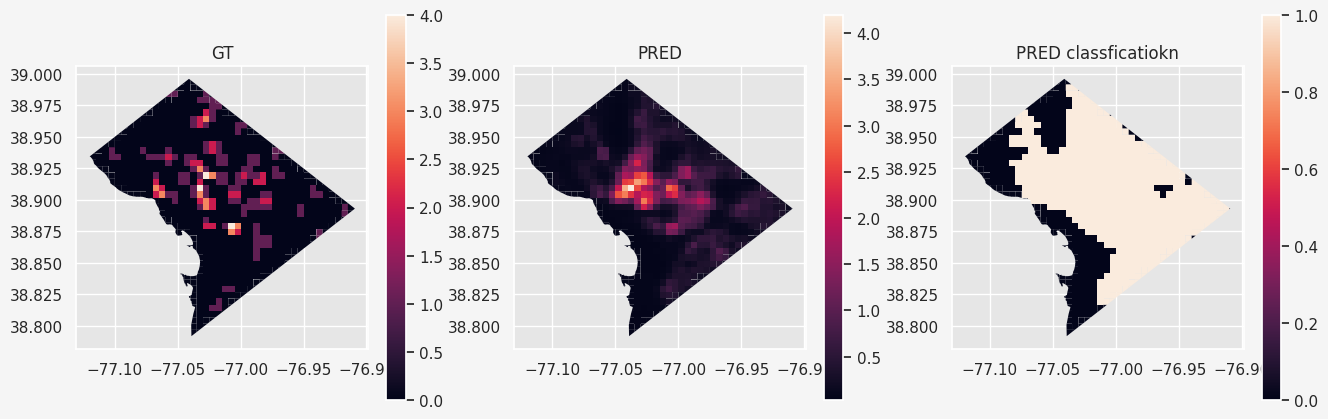

In [356]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))
axs = np.ravel(axs)
sel_idx=3
nets['y']=gt[sel_idx,:]
nets.plot(column='y',legend=True, ax=axs[0],edgecolor='none')

nets['y']=pred[sel_idx,:]
nets.plot(column='y',legend=True, ax=axs[1],edgecolor='none')

nets['y']=pred_c[sel_idx,:]
nets.plot(column='y',legend=True, ax=axs[2],edgecolor='none')

# nets['y']=gt[sel_idx+7,:]
# nets.plot(column='y',legend=True, ax=axs[3])

# nets['y']=pred[sel_idx+7,:]
# nets.plot(column='y',legend=True, ax=axs[4])

# nets['y']=pred_c[sel_idx+7,:]
# nets.plot(column='y',legend=True, ax=axs[5])

axs[0].set_title('GT')
axs[1].set_title('PRED')
axs[2].set_title('PRED classficatiokn')

  9 -- train loss: 0.00085416
 19 -- train loss: 0.00083752
 29 -- train loss: 0.00085389
 39 -- train loss: 0.00082642
 49 -- train loss: 0.00083250
 59 -- train loss: 0.00084194
 69 -- train loss: 0.00080970
 79 -- train loss: 0.00081551
 89 -- train loss: 0.00080069
 99 -- train loss: 0.00079093
test
test loss: 0.00286326


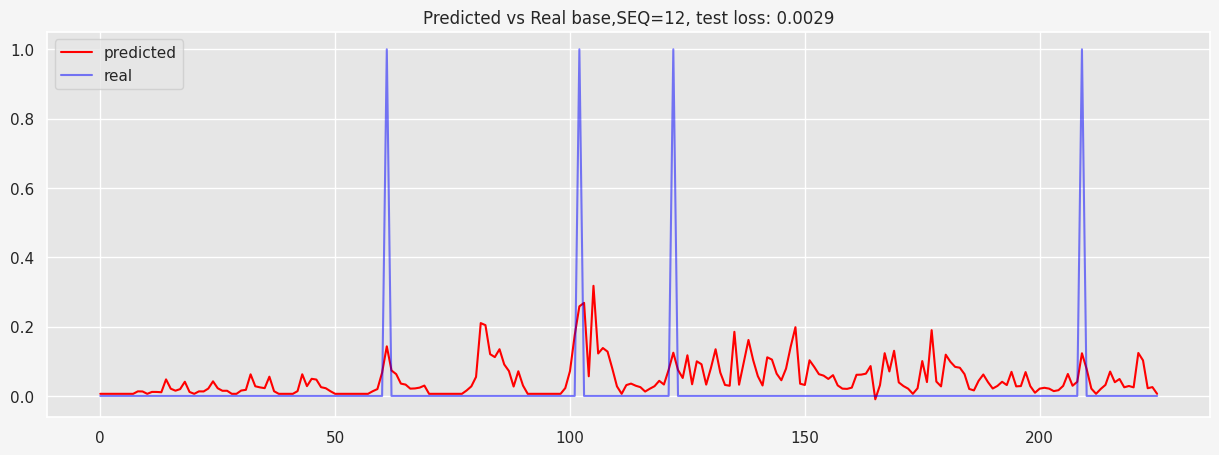

In [312]:
MODEL_NAME='base'
model=BaseModel(3,'GCN', 256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
# initialize the loss function using mean squared error
crit=nn.MSELoss()
history=[]
test_history=[]
best_validate_mae = np.inf
validate_score_non_decrease_count = 0
best_epoch=0
for epoch in range(100):
    loss=train(model,train_data_loader,optimizer,crit)
    history.append(loss)
#      progress monitor:
    if (epoch+1) % 10==0:
        print(f'{epoch:3d} -- train loss: {loss:.8f}')
        
print('test')
test_loss,pred,gt=test(model,test_data_loader,crit)
print(f'test loss: {test_loss:.8f}')

# plot
plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
plt.plot(pred[0,:], label='predicted', color='red')
plt.plot(gt[0,:], label='real', color='blue',alpha=0.5)
plt.legend(loc='best')
plt.title(f'Predicted vs Real {MODEL_NAME},SEQ={SEQ}, test loss: {test_loss:.4f}')
plt.show()